# Import needed modules and useful functions

In [2]:
#-- useful python script for training the DeepTICA cvs --#
from utils import *

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

# Simulation parameters 

In [3]:
kb=0.008314
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'temp':300, 
    'beta': 1./(300*kb),
    'kbt': None,
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :70,
}
#--------------------------------------#

# Prepare input files for plumed

In [4]:
folder = "unbias_A/bias1/"

Path(folder).mkdir(parents=True, exist_ok=True)

with open(folder+"plumed.dat","w") as file:
    print("""
# vim:ft=plumed

MOLINFO STRUCTURE=input.ala2.pdb
phi: TORSION ATOMS=@phi-2
psi: TORSION ATOMS=@psi-2
ene: ENERGY

# include descriptors
INCLUDE FILE=plumed_descriptors.data
# define cv
deep: PYTORCH_MODEL FILE=../deeptica/model.ptc ARG=d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45
# bias 
opes: OPES_METAD ARG=deep.node-0,deep.node-1 TEMP=300 PACE=500 FILE=KERNELS BARRIER=40 STATE_WFILE=RestartKernels STATE_WSTRIDE=500*10
 
PRINT FMT=%g STRIDE=500 FILE=COLVAR ARG=*

ENDPLUMED
""",file=file)

#-- run gromacs --#
#execute("cp script/input.* script/plumed_descriptors.data script/run_gromacs.sh "+folder,folder=".")
#execute("./run_gromacs.sh",folder=folder)

data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^d[^a-z]').columns.values
data_complete = load_dataframe("angles/COLVAR")
X_complete = data_complete[descriptors_names].to_numpy()

Text(0, 0.5, '$\\psi$')

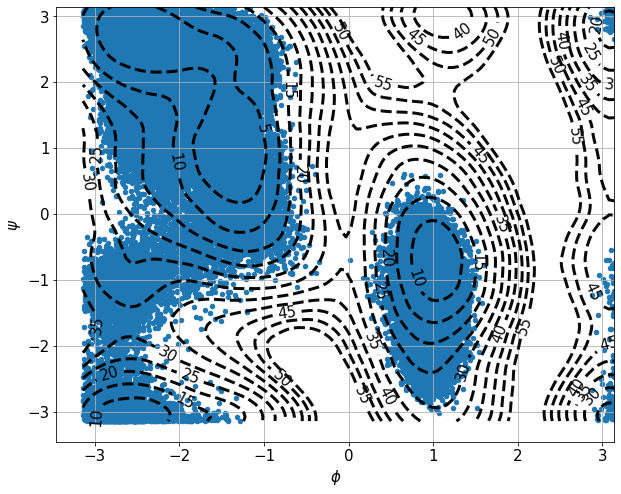

In [5]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
load_dataframe(folder+"COLVAR").plot.scatter(y="psi",x="phi",ax=ax)

fes = np.loadtxt("angles/fes.txt",delimiter=" ")
grid0 = np.loadtxt("angles/grid0.txt",delimiter=" ")
grid1 = np.loadtxt("angles/grid1.txt",delimiter=" ")
bounds = np.arange(0, 60, 5.)
c = ax.contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c.clabel()
ax.grid()
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\psi$")

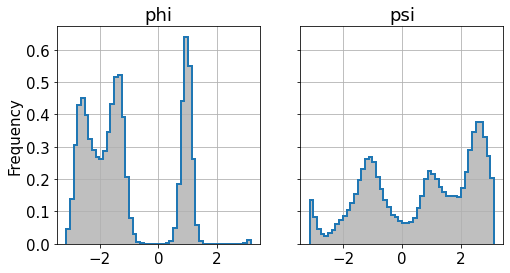

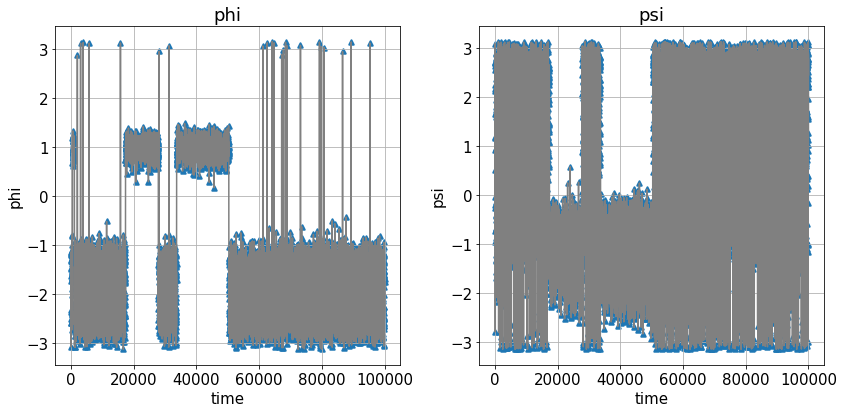

In [6]:
data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^p').columns.values

fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[desc].plot.hist(bins=50,alpha=1,ax=ax,legend=False,grid=True,histtype='step',linewidth=2,density=True)
    data[desc].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False,grid=True,color="grey",density=True)
    ax.set_title(desc)

fig,axs = plt.subplots(1,2,figsize=(12,6))

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[::10].plot.scatter(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,linewidth=2,marker="^")
    data[::10].plot.line(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,color="grey")
    ax.set_title(desc)

plt.tight_layout()

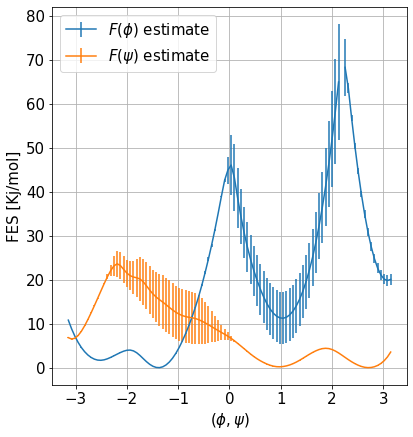

In [7]:
#-- estimation of Free Energy Surface --#
s = load_dataframe(folder+"COLVAR").filter(regex="^p").to_numpy()
logweight = np.transpose( load_dataframe(folder+"COLVAR").filter(regex="^opes.bias$").to_numpy() )[0]*sim_parameters["beta"]
logweight = logweight - np.max(logweight)

fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        temp=sim_parameters["temp"],
                                        kbt=sim_parameters["kbt"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend([r"$F(\phi)$ estimate",r"$F(\psi)$ estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(\phi,\psi)$")
ax.set_ylabel("FES [Kj/mol]")

plt.show()

In [8]:
#gridspec_fes(s,logweight,sim_parameters)

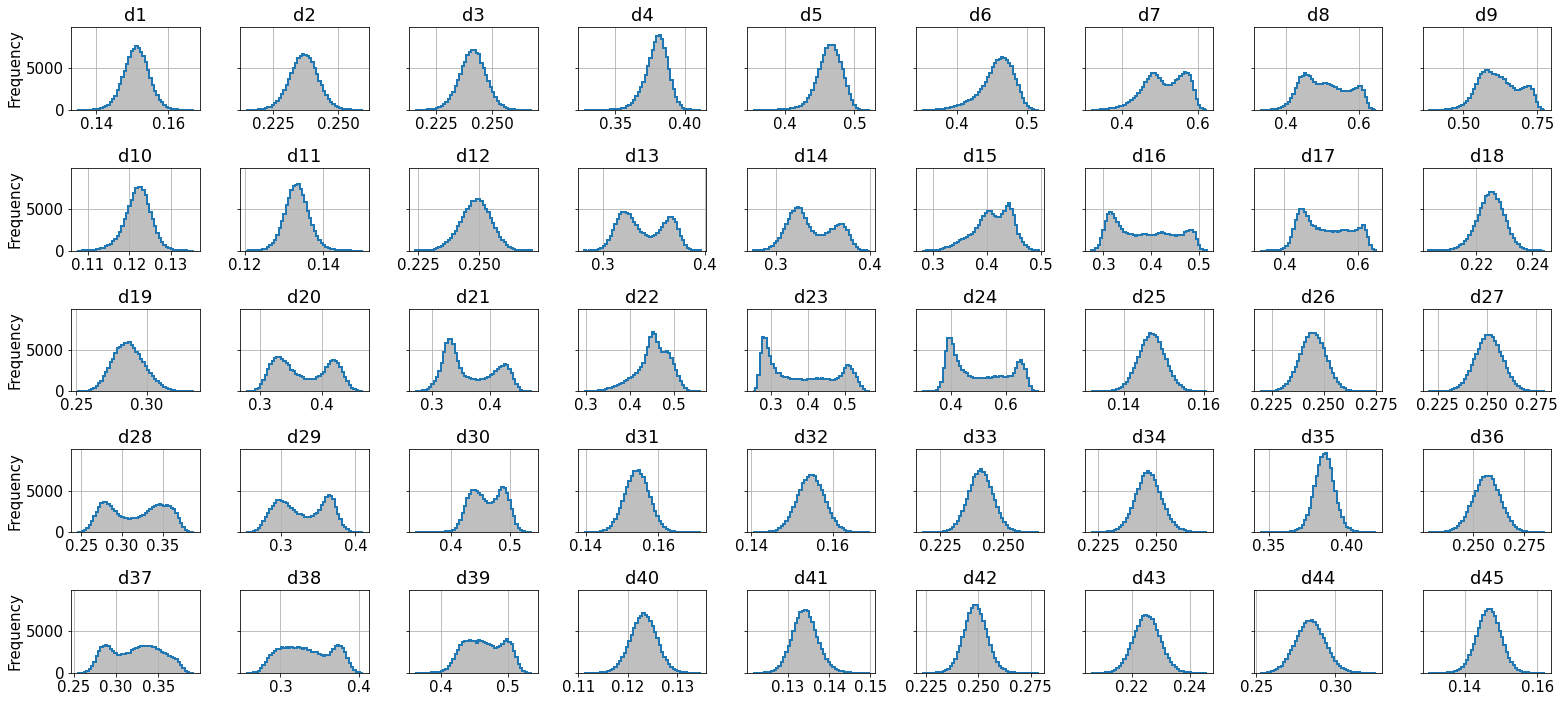

In [9]:
data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^d[^a-z]').columns.values

fig,axs = plt.subplots(5,9,figsize=(22,10),sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[desc].plot.hist(bins=50,alpha=1,ax=ax,legend=False,grid=True,histtype='step',linewidth=2)#,density=True)
    data[desc].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False,grid=True,color="grey")#,density=True)
    ax.set_title(desc)

plt.tight_layout()

In [10]:
'''
#-- compile cpp, longest procedure --#
execute("make",folder=folder)
#-- remove old files
#execute("rm w_lag.txt w_t.txt x_lag.txt x_t.txt",folder=folder, print_result=False)

#-- write input file to create time lagged dataset --#
path = "COLVAR"
names = load_dataframe(folder+path).filter(regex="^d[^a-z]").columns
first_index = data.columns.get_loc(names[0])
last_index = data.columns.get_loc(names[-1])
weights_index = data.columns.get_loc("opes.bias")
skip = 4 #skip the first four rows after the header 
with open(folder+"input.dat","w") as file:
    print("""colvar = """+path+"""
skip_rows = """+str(skip)+"""
beta = """+str(sim_parameters["beta"])+"""
lag = 1
first_index = """+str(first_index)+"""
last_index = """+str(last_index)+"""
if_weights = 1
weights_index = """+str(weights_index)+"""
""",file=file)
'''

'\n#-- compile cpp, longest procedure --#\nexecute("make",folder=folder)\n#-- remove old files\n#execute("rm w_lag.txt w_t.txt x_lag.txt x_t.txt",folder=folder, print_result=False)\n\n#-- write input file to create time lagged dataset --#\npath = "COLVAR"\nnames = load_dataframe(folder+path).filter(regex="^d[^a-z]").columns\nfirst_index = data.columns.get_loc(names[0])\nlast_index = data.columns.get_loc(names[-1])\nweights_index = data.columns.get_loc("opes.bias")\nskip = 4 #skip the first four rows after the header \nwith open(folder+"input.dat","w") as file:\n    print("""colvar = """+path+"""\nskip_rows = """+str(skip)+"""\nbeta = """+str(sim_parameters["beta"])+"""\nlag = 1\nfirst_index = """+str(first_index)+"""\nlast_index = """+str(last_index)+"""\nif_weights = 1\nweights_index = """+str(weights_index)+"""\n""",file=file)\n'

In [11]:
#fast way to produce time autocorrelation function 

#-- fast way, one descriptor at once --#
#fig,axs = plt.subplots(2,1,figsize=(14,10))#,sharey=True)

#-- in ps --#
#last=10000
#x = np.linspace(0,last+1,last)
#acorr = np.array( [my_autocorrelation_cpp_all("input.dat",lag=i,path=folder,weight=True) for i in range(last)] )
#timescale = np.empty(len(descriptors_names))

#for k in range(len(descriptors_names)):
#    corr = acorr.T[k]
#    axs[0].plot(x,corr)
#    timescale[k] = integrate.trapz(corr[:last],x[:last])

#times = pd.DataFrame(descriptors_names,columns=["descriptors"])
#times["timescale"] = timescale
#times.plot(kind="bar",x="descriptors",y="timescale",rot=35,ax=axs[1],fontsize=15,label=r"$\xi$")

#axs[0].set_xlabel(r'$\tau$')
#axs[0].set_title(r'$C(\tau)$')
#axs[1].set_title(r'$\xi=\int d\tau C(\tau)$')

#plt.tight_layout()
#plt.show()

#print(np.max(timescale))
#print(np.min(timescale))

In [26]:
#-- TRAINING PARAMETERS --#
n_output = 2
n_input = 45
train_parameters = {
              'descriptors': '^d[^a-z]',
              'nodes':[n_input,30,30,n_output], 
              'activ_type': 'tanh',
              'lag_time':10,
              'loss_type': 'sum', 
              'n_eig': n_output,
              'trainsize':0.7,
              'lrate':1e-3,
              'l2_reg':0.,
              'num_epochs':1500,
              'earlystop':True,
              'es_patience':300,
              'es_consecutive':True,#False,
              'standardize_outputs':True,
              'standardize_inputs': True,
              'log_every':500,
              #if reweight the timescale
              "reweighting": True,
              "path_cpp": folder,#None
              }
#--------------------------------------#

## check for which lag time the gap is maximum  
In this case che computational cost could be high, so I use the `create_time_lagged_dataset_cpp` implementation.  
`train_parameters[path_cpp]` is the path to the folder in which execute `create_time_lagged_dataset_cpp`

In [27]:
''' already done
#-- write input file to create time lagged dataset --#
path = "COLVAR"
names = load_dataframe(folder+path).filter(regex="^d[^a-z]").columns
first_index = data.columns.get_loc(names[0])
last_index = data.columns.get_loc(names[-1])
weights_index = data.columns.get_loc("opes.bias")
skip = 4 #skip the first four rows after the header 
with open(folder+"input.dat","w") as file:
    print("""colvar = """+path+"""
skip_rows = """+str(skip)+"""
beta = """+str(sim_parameters["beta"])+"""
lag = 1
first_index = """+str(first_index)+"""
last_index = """+str(last_index)+"""
if_weights = 1
weights_index = """+str(weights_index)+"""
""",file=file)
'''

' already done\n#-- write input file to create time lagged dataset --#\npath = "COLVAR"\nnames = load_dataframe(folder+path).filter(regex="^d[^a-z]").columns\nfirst_index = data.columns.get_loc(names[0])\nlast_index = data.columns.get_loc(names[-1])\nweights_index = data.columns.get_loc("opes.bias")\nskip = 4 #skip the first four rows after the header \nwith open(folder+"input.dat","w") as file:\n    print("""colvar = """+path+"""\nskip_rows = """+str(skip)+"""\nbeta = """+str(sim_parameters["beta"])+"""\nlag = 1\nfirst_index = """+str(first_index)+"""\nlast_index = """+str(last_index)+"""\nif_weights = 1\nweights_index = """+str(weights_index)+"""\n""",file=file)\n'

In [28]:
'''
# per questi lags e con 3 semi diversi: python -> 50 minuti; cpp -> 18 minuti
lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,18,25]
# per questi faccio solo cpp
lags = np.linspace(1,20,50)
time = []
seeds = [21]#,151],500]
for seed in seeds:
    timescale = np.empty(len(lags))
    for i,lag in enumerate(lags):
        train_parameters["lag_time"] = lag
        #-- modify lag time in input file --#
        torch.manual_seed(seed)
        model,data,logweight,X = training(sim_parameters["beta"],folder+"COLVAR",train_parameters)

        #-- move the model back to cpu for convenience --# 
        model.to('cpu')
        #-- save gap between eigenvalues
        timescale[i] = model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1]
    time.append(timescale)
'''

'\n# per questi lags e con 3 semi diversi: python -> 50 minuti; cpp -> 18 minuti\nlags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,18,25]\n# per questi faccio solo cpp\nlags = np.linspace(1,20,50)\ntime = []\nseeds = [21]#,151],500]\nfor seed in seeds:\n    timescale = np.empty(len(lags))\n    for i,lag in enumerate(lags):\n        train_parameters["lag_time"] = lag\n        #-- modify lag time in input file --#\n        torch.manual_seed(seed)\n        model,data,logweight,X = training(sim_parameters["beta"],folder+"COLVAR",train_parameters)\n\n        #-- move the model back to cpu for convenience --# \n        model.to(\'cpu\')\n        #-- save gap between eigenvalues\n        timescale[i] = model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1]\n    time.append(timescale)\n'

In [29]:
'''
#-- plot results --#
for j,el in enumerate(time):
    plt.plot(lags,el,label="sample"+str(j))
plt.legend()
print(time[0])
print(lags)
'''

'\n#-- plot results --#\nfor j,el in enumerate(time):\n    plt.plot(lags,el,label="sample"+str(j))\nplt.legend()\nprint(time[0])\nprint(lags)\n'

## DeepTICA Analysis and Export

In [48]:
%%time
torch.manual_seed(21)
train_parameters["lag_time"] = 10
train_parameters["path_cpp"] = None
#-- modify lag time in input file --#
model,data,logweight,X = training(sim_parameters["beta"],folder+"COLVAR",train_parameters)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

#-- export checkpoint (for loading the model back to python) and torchscript traced module --#
save_folder = folder+"deeptica/"
try:
    os.mkdir(save_folder)
except:
    print("already exists")
#-- move to cpu before saving results --#
model.to("cpu")
model.export(save_folder)
print("model saved")

#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())
print("gap: ", model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1])

Epoch Train Loss  Valid Loss  Eigenvalues             
500   -1.376      -1.346      0.987  0.388  
1000  -1.401      -1.366      0.996  0.405  
1500  -1.416      -1.373      0.997  0.419  
already exists
model saved
timescales:  [2909.3274    11.50861]
eigenvalues:  [0.9965687  0.41940653]
gap:  0.57716215
CPU times: user 1min 43s, sys: 11.8 s, total: 1min 54s
Wall time: 1min 41s


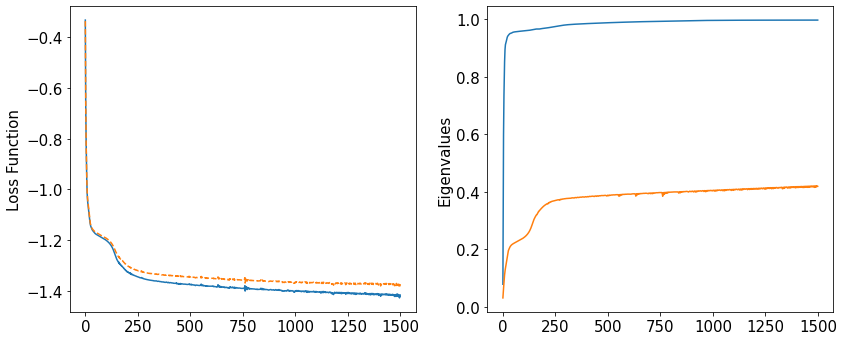

In [49]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [50]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]
data_complete["cv1"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[0]
data_complete["cv2"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[1]

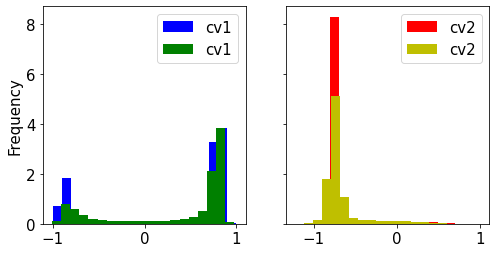

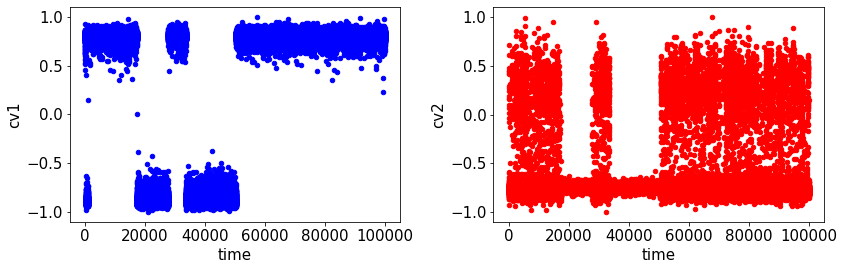

In [51]:
# histogram
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")
data_complete.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="g")
data_complete.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="y")
# scatter
fig,axs = plt.subplots(1,2,figsize=(12,4))
data.plot.scatter(y="cv1",x="time",ax=axs[0],color="b")
data.plot.scatter(y="cv2",x="time",ax=axs[1],color="r")

plt.tight_layout()

We can also plot the correlation (*Pearson* correlation ,which simply means normed correlation) of the Deep-TICA cvs with the descriptors

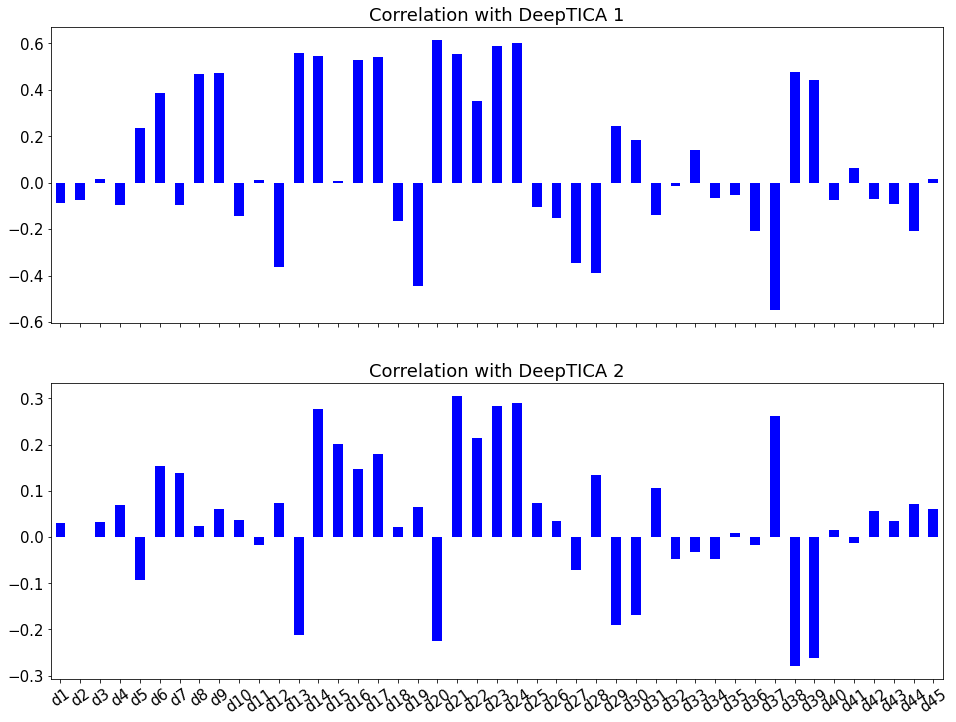

In [52]:
fig,axs = plt.subplots(2,1,figsize=(16,12),sharex=True)
for k,cv in enumerate(["cv1","cv2"]):
    cols = [cv]
    cols.extend(data.filter(regex=train_parameters["descriptors"]).columns)
    corr = data[cols].corr(method='pearson')
    corr[cv].drop(cv).plot(kind='bar', ax=axs[k], rot=35, color="b",label=r"$C(deep|desc)$")
    axs[k].set_title('Correlation with DeepTICA '+str(k+1))
plt.show()

In [53]:
#fig,ax = plt.subplots(1,1,figsize=(18,6))
#times["timescale"] = times["timescale"]/np.max(times["timescale"])
#cols = ["cv1"]
#cols.extend(data.filter(regex=train_parameters["descriptors"]).columns)
#corr = data[cols].corr(method='pearson')
#times["corr"] = np.abs(corr["cv1"].to_numpy()[1:])
#times.plot(kind="bar",x="descriptors",rot=35,ax=ax,fontsize=15,stacked=False)
#ax.set_title(r'Correlation with DeepTICA 1 vs $\xi$')
#ax.legend([r"$\frac{\xi}{max(\xi)}$",r"$|C(deep|desc)|$"])
#plt.show()

### FES estimate from new cvs   

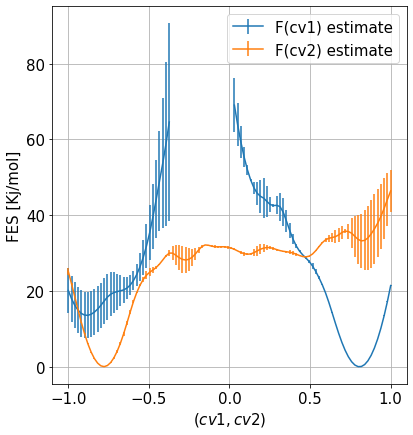

In [54]:
#-- estimation of Free Energy Surface --#
s = data.filter(regex="^cv").to_numpy()
logweight = np.transpose( load_dataframe(folder+"COLVAR").filter(regex="^opes.bias$").to_numpy() )[0]*sim_parameters["beta"]
logweight = logweight - np.max(logweight)

fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        temp=sim_parameters["temp"],
                                        kbt=sim_parameters["kbt"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(cv1) estimate","F(cv2) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(cv1,cv2)$")
ax.set_ylabel("FES [Kj/mol]")

plt.show()

### FES estimate from old cvs  

In [55]:
'''
s = data.filter(regex="^deep.node-").to_numpy()

fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        temp=sim_parameters["temp"],
                                        kbt=sim_parameters["kbt"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(deep1) estimate","F(deep2) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(deep1,deep2)$")
ax.set_ylabel("FES [Kj/mol]")

plt.show()
'''

'\ns = data.filter(regex="^deep.node-").to_numpy()\n\nfig, ax = plt.subplots(figsize=(6,6))\nfor i in range(2):\n    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),\n                                        temp=sim_parameters["temp"],\n                                        kbt=sim_parameters["kbt"],\n                                        blocks=sim_parameters["blocks"],\n                                        bandwidth=sim_parameters["bandwidth"],scale_by=\'range\',\n                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)\nax.legend(["F(deep1) estimate","F(deep2) estimate"])   \nax.grid()\nplt.tight_layout()\nax.set_xlabel(r"$(deep1,deep2)$")\nax.set_ylabel("FES [Kj/mol]")\n\nplt.show()\n'

### Isolines  
We can use the data obtained from **angles** folder, biasing both $\psi$ and $\phi$ angles, to plot the isolines of the new Cvs   

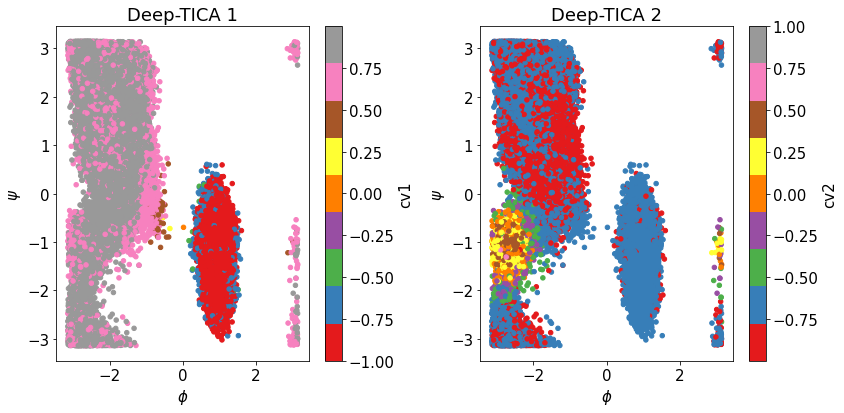

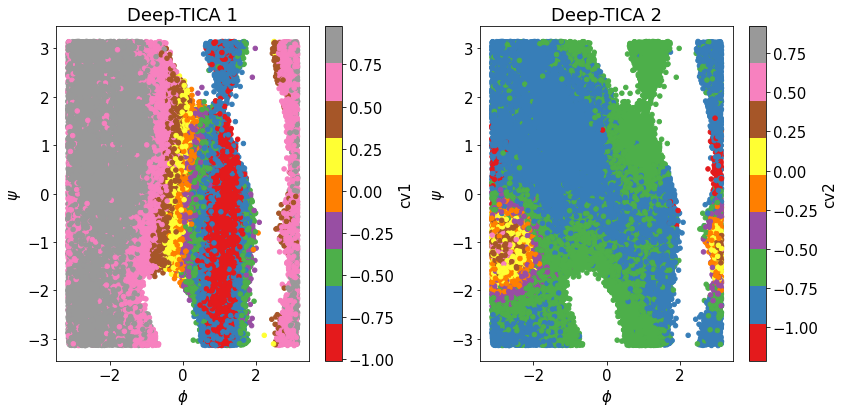

In [56]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data_complete.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

In [15]:
''' symbolic regression, file: hall_of_fame_2022-05-04_174509.174.csv
X = data_complete[["phi","psi"]]#.to_numpy()
y = data_complete["cv1"]#.to_numpy()
from pysr import PySRRegressor
model = PySRRegressor(
    niterations=5,
    binary_operators=["+", "*", "-", "/"],
    unary_operators=[
        "cos",
        "exp",
        "sin",
        "tanh",
        # non c'è step function
        #"inv(x) = 1/x",  # Custom operator (julia syntax)
    ],
    model_selection="best",
    loss="loss(x, y) = (x - y)^2",  # Custom loss function (julia syntax)
)
model.fit(X, y)
'''

In [ ]:
# tanh(0.63686156 - sin(x0 - -0.44599095)) best result // best score x0 = phi

### Orthogonality  
We said that the **ICs** must satisfy two conditions. The first one is that they are uncorrelated, which means that $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta U(\vec x)} = 0$.  
But their scalar product on the data will lead to a slightly different result, in this case approximately $0$, but not perfectly $0$

In [25]:
Boltzmann_product(model,model,X,j=0,k=1,logweight=logweight)

-0.06107732981980081

This results reflects the fact that we have enforce the symmetrization of $C(\tau)$  
then one can enforce the orthogonality on the data